<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ENEE439d-TEXTML/TextML/blob/master/input.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/ENEE439d-TEXTML/TextML/blob/master/input.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Imports

In [1]:
!pip install -q -U "tensorflow-text==2.8.*" # A dependency of the preprocessing for BERT inputs
!pip install -q tf-models-official==2.7.0 # For adamW
!pip install focal-loss # focal loss implmnetion for tf

     |████████████████████████████████| 4.9 MB 8.5 MB/s 
     |████████████████████████████████| 462 kB 47.2 MB/s 
     |████████████████████████████████| 1.8 MB 7.4 MB/s 
     |████████████████████████████████| 596 kB 44.5 MB/s 
     |████████████████████████████████| 237 kB 45.3 MB/s 
     |████████████████████████████████| 352 kB 34.1 MB/s 
     |████████████████████████████████| 43 kB 1.0 MB/s 
     |████████████████████████████████| 1.1 MB 37.5 MB/s 
     |████████████████████████████████| 47.8 MB 75 kB/s 
     |████████████████████████████████| 1.2 MB 49.7 MB/s 
     |████████████████████████████████| 99 kB 2.8 MB/s 
     |████████████████████████████████| 90 kB 8.4 MB/s 


In [2]:
import pandas as pd #basic imports
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras import layers
import re

In [3]:
from sklearn.model_selection import train_test_split # https://www.tensorflow.org/text/tutorials/classify_text_with_bert
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization, bert  # to create AdamW optimizer
from focal_loss import SparseCategoricalFocalLoss
import official.nlp.bert.tokenization

# Data read in

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
filepath = '/content/drive/MyDrive/Text-ML/full_sentiment_dataset.csv' #'data.csv'
df= pd.read_csv(filepath)
df1=df.drop(['no','paper','context_a','context_b'],axis=1)
df1.head()

,cited_paper,label,text
0,A00-2024,0,We analyzed a set of articles and identified s...
1,A00-2024,0,Table 3: Example compressions Compression AvgL...
2,A00-2024,0,5.3 Related works and discussion Our two-step ...
3,A00-2024,0,(1999) proposed a summarization system based o...
4,A00-2024,0,We found that the deletion of lead parts did n...


In [6]:
df1['label'].value_counts()

 0    7627
 1     829
-1     280
Name: label, dtype: int64

# Filtering by regex

In [7]:
context=df1['text']

re1= "\(((([A-Za-z]+ *)+(, \d+))+(; )*)+\)" # matches author and author, year
re_year=",? \(?\d{4}\)?" # match , {4 digits} which may be wrapped in () 
re_and="(and|&) "
re_auth="((\w+, )*(\w+ )+)"
re_et= re_auth+"et al\. ?"+re_year # matches author et al. , year
re_2a= re_auth+"("+re_and+"((\w+ *))?)?"+re_year # matches author and author, year
re_sep="((; )|( "+re_and+"))*"# match the '; ' gap or ' and ' gap
re_para_year="\(\d{4}\)"
re_in_brack="\[*\]"
re_apa =re_in_brack+"|"+re_para_year+"|"+"\(?("+"(\(?"+re_2a+"|"+re_et+"\)?)"+re_sep+")+"
print(re_apa)

\[*\]|\(\d{4}\)|\(?((\(?((\w+, )*(\w+ )+)((and|&) ((\w+ *))?)?,? \(?\d{4}\)?|((\w+, )*(\w+ )+)et al\. ?,? \(?\d{4}\)?\)?)((; )|( (and|&) ))*)+


In [8]:
def remove_matches(text,regex=re_apa):
  text1=text
  rem_len=0
  pattern= re.compile(regex)
  while True:
    matches=pattern.search(text1)
    #print(matches)
    if matches == None:
      break

    spn=matches.span()
    text1=text1[0:spn[0]]+text1[spn[1]:-1]
    cit_len=spn[1]-spn[0]
    rem_len+=cit_len
  
  if len(text) >0:
    percent_removed=rem_len/len(text)
  else:
    percent_removed=1
  return text1,percent_removed 

# print(context[5])
# remove_citation(context[5],regex=re_apa)

In [9]:
output=df1['text'].apply(lambda x: remove_matches(text=x,regex=re_apa)) #df['col1'] = df.apply(lambda x: complex_function(x['col1']), axis=1)
df_o = pd.DataFrame(list(output), columns =['clean','p_rem'])
output_1=df_o['clean'].apply(lambda x: remove_matches(text=x,regex='[^\w_0-9 ]+')) 
df_o_1 = pd.DataFrame(list(output_1), columns =['clean','p_rem'])
#df_o.head()

df1['text_clean']=df_o_1['clean']
df1['text_clean_len']=df_o_1['clean'].apply(len)
df1['p_rem']=df_o['p_rem']

In [10]:
df1

,cited_paper,label,text,text_clean,text_clean_len,p_rem
0,A00-2024,0,We analyzed a set of articles and identified s...,We analyzed a set of articles and identified s...,425,0.098765
1,A00-2024,0,Table 3: Example compressions Compression AvgL...,Table 3 Example compressions Compression AvgLe...,229,0.260745
2,A00-2024,0,5.3 Related works and discussion Our two-step ...,53 Related works and discussion Our twostep mo...,105,0.308176
3,A00-2024,0,(1999) proposed a summarization system based o...,proposed a summarization system based on the ...,321,0.078804
4,A00-2024,0,We found that the deletion of lead parts did n...,We found that the deletion of lead parts did n...,73,0.408000
...,...,...,...,...,...,...
8731,W96-0213,1,He has achieved state-of-the art results by ap...,He has achieved stateofthe art results by appl...,139,0.151515
8732,W96-0213,0,"B = (Brill and Wu, 1998); M = (Magerman, 1995)...",B M Magerman 1995 O our data R Ratnaparkhi 1,48,0.421488
8733,W96-0213,0,The model we use is similar to that of (Ratnap...,The model we use is similar to that of Ratnapa...,55,0.000000
8734,W96-0213,1,Our model exploits the same kind of tag-n-gram...,Our model exploits the same kind of tagngram i...,157,0.000000


# Remove under and over sized samples
large samples appear to be poorly written

In [11]:
def getMidLen(data,label,labelKey='label',lenKey='text_clean_len',lowMod=1,highMod=1):
  df1 =data.loc[data[labelKey] == label]
  neu_mean=np.mean(list(df1[lenKey]))
  neu_std=np.std(list(df1[lenKey]))
  df1_no_high = df1.loc[df1[lenKey] < highMod*(neu_mean +neu_std)]
  # print(neu_mean)
  # print(neu_std)

  while neu_std > neu_mean:
    neu_mean=np.mean(list(df1_no_high['text_clean_len']))
    neu_std=np.std(list(df1_no_high['text_clean_len']))
    # print(neu_mean)
    # print(neu_std)
    df1_no_high = df1.loc[df1['text_clean_len'] < highMod*(neu_mean +neu_std)]

  df1_mid = df1_no_high.loc[df1_no_high['text_clean_len'] > lowMod*(neu_mean -neu_std)]

  return df1_mid

df2 = df1.loc[df1['p_rem'] < .5] #keep sampels with less than half of it are citation

df_neu=getMidLen(df2,0,lowMod=2)
df_pos=getMidLen(df2,1,lowMod=1,highMod=2)
df_neg=getMidLen(df2,-1,lowMod=1,highMod=2)
df3= pd.concat([df_neg,df_neu,df_pos])
df3['label'].value_counts()

 0    2524
 1     746
-1     246
Name: label, dtype: int64

In [12]:
def catagorize(data,labelKey='label'):
  rows=len(data.index)
  onehots=np.zeros((rows,3),dtype=int)
  for i,lab in enumerate(data[labelKey]):
    onehots[i][lab+1]=1
  return onehots

hots=catagorize(df3)
df3['label_onehot']=list(hots)
df3['label_index']=df3['label']+1

In [13]:
freq= np.array(list(df3['label_index'].value_counts(normalize=True,sort=False)))
print(freq)
class_ratio= 1/freq
class_ratio

[0.06996587 0.71786121 0.21217292]


array([14.29268293,  1.39302694,  4.71313673])

#Load Model

In [14]:
X_train, X_test, y_train, y_test = train_test_split(list(df3['text_clean']), list(df3['label_index']), test_size=0.2, random_state=42)
X_train= [[s] for s in X_train]
X_test= [[s] for s in X_test]
y_train=[[s] for s in list(y_train)]
y_test=[[s] for s in list(y_test)]

In [15]:
#@title Choose a BERT model to fine-tune (Taken from tutorial)

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## check model passes

In [16]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [17]:
text_test = X_train[1]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  1999  5688 11416  6024  4275  2024  4738  2000 25845  1996  4101]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [18]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [19]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.99835694 -0.7678578  -0.21300124  0.08411987 -0.08593949  0.98550844
  0.9732349  -0.8306031  -0.55687106 -0.95725054 -0.3960305  -0.94115573]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 3.8915187e-01  2.3267061e-01  6.1780311e-02 ... -9.2866874e-01
   4.3027106e-01  8.3279318e-01]
 [ 4.5310837e-01  7.2308904e-01 -3.2866317e-01 ... -1.1163950e-04
  -3.3482751e-01  5.7274055e-01]
 [-2.5876865e-01  1.4199525e+00 -4.2525381e-01 ...  4.9038833e-01
   1.4491324e-01  5.7048750e-01]
 ...
 [ 2.6529512e-01 -2.3668993e-01  8.4921330e-02 ...  2.0211086e-02
   3.9103544e-01  8.9449620e-01]
 [ 2.9499257e-01  5.8424294e-01 -6.7344594e-01 ... -1.6148384e+00
   1.3211843e+00 -6.0517174e-01]
 [-1.8697177e-01  5.2527428e-01  9.2377967e-01 ... -5.6088662e-01
   1.0293359e+00 -7.8856331e-01]]


## full model setup

In [20]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [21]:
classifier_model = build_classifier_model()

## check loss function

In [22]:
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

l =  SparseCategoricalFocalLoss(gamma=2,class_weight=class_ratio)
test =tf.convert_to_tensor([1.0])
l(test,bert_raw_result)

tf.Tensor([[0.10724457 0.636404   0.25635144]], shape=(1, 3), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.08322639>

# Train Save and Log

In [23]:
epochs = 5
steps_per_epoch = 200 #tf.data.experimental.cardinality(X_train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 2e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

# def auc_wrapper(y_true,y_pred):
#   print(y_true,y_pred)

#   y_true=tf.reshape(y_true,[1])
#   print(y_true)
#   y_true= tf.cast(y_true, tf.int32)
#   print(y_true)
#   y_true=tf.one_hot(y_true,depth=3)
#   print(y_true)
#   return tf.keras.metrics.AUC(multi_label=True)(y_true,y_pred)


loss =  SparseCategoricalFocalLoss(gamma=2,class_weight=class_ratio) #tf.keras.losses.MeanSquaredError()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]#, auc_wrapper]#, tf.keras.metrics.AUC(multi_label=True)]


classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="citation_BERT_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_sparse_categorical_accuracy",
        verbose=1
    ),
    tf.keras.callbacks.TensorBoard('./logs', update_freq=1)
]


In [24]:
# print(f'Training model with {tfhub_handle_encoder}')
# history = classifier_model.fit(x=X_train,y=y_train, validation_data=(X_test,y_test),epochs=epochs,callbacks= callbacks, verbose=True)

In [25]:
# classifier_model.save_weights(''/content/drive/MyDrive/Text-ML/checkpoint1')

## Inspect model

In [26]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [27]:
#%tensorboard --logdir=logs

In [28]:
classifier_model.load_weights('/content/drive/MyDrive/Text-ML/checkpoint')

In [29]:
preds=classifier_model.predict(X_train,verbose=1)

88/88 [==============================] - 192s 2s/step


In [30]:
preds_t=classifier_model.predict(X_test,verbose=1)

22/22 [==============================] - 45s 2s/step


In [31]:
import seaborn as sns; sns.set_theme()

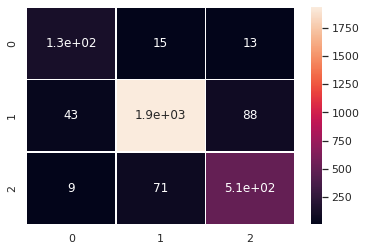

In [32]:
c_mat=tf.math.confusion_matrix(np.argmax(preds,-1),y_train)
ax = sns.heatmap(c_mat,annot=True,linewidths=.5)

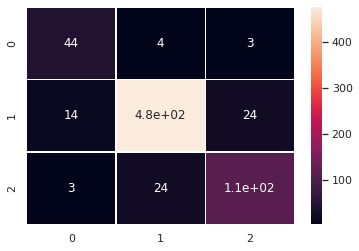

In [33]:
c_mat=tf.math.confusion_matrix(np.argmax(preds_t,-1),y_test)
ax = sns.heatmap(c_mat,annot=True,linewidths=.5)

# Get attention colorings

https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1


In [34]:
classifier_model.layers

In [35]:
from official.nlp import bert 
import official.nlp.bert.tokenization

In [36]:
tokenizer = bert.tokenization.FullTokenizer(vocab_file='/content/drive/MyDrive/Text-ML/vocab.txt')
preprocesser_model = keras.Model(inputs=classifier_model.input,outputs=classifier_model.get_layer('preprocessing').output)
encoder_model = keras.Model(inputs=classifier_model.input,outputs=classifier_model.get_layer('BERT_encoder').output)

In [37]:
print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


## Attnetion token mapping

In [38]:
def get_attn(context,prep,encoder): # assume stirng array input
  t_context=tf.convert_to_tensor(context)

  p_out=prep(t_context)
  #print(p_out)
  stop_index=0
  while(stop_index< p_out["input_mask"].shape[1] and p_out["input_mask"][0][stop_index] == 1):
    stop_index+=1
  
  if stop_index >= 128:
    stop_index=127

  output = encoder(t_context)
  #print(output["sequence_output"].shape)
  valid_entries=output["sequence_output"][:,1:stop_index-1,:]
  a=tf.math.reduce_mean(valid_entries,-1)
  mean=tf.math.reduce_mean(a,-1,keepdims=True)
  std=tf.math.reduce_std(a,-1,keepdims=True)
  a1=(a-mean)/std

  return a1

In [39]:
def get_attn_for_words(context,tokenizer,prep,encoder):
  attn = get_attn(context,prep,encoder).numpy()
  tokens = tokenizer.tokenize(context[0]) 

  indicies=np.ones((len(tokens)),dtype=int)
  for i,tok in enumerate(tokens):
    if '##' in tok:
      indicies[i]=0

  full_words=tokens.copy()
  ix=-1
  for i,tok in enumerate(tokens):
    if not indicies[i]:
      attn[0][ix]+=attn[0][i]
      full_words[ix]+=tok[2:]
    else:
      ix=i

  t_f=tf.convert_to_tensor(full_words) #stores as byte string...
  masked_f=tf.boolean_mask(t_f,indicies)
  t_a=tf.convert_to_tensor(attn)[0]
  masked_a=tf.boolean_mask(t_a[:len(indicies)],indicies)
  

  return masked_f.numpy(),masked_a.numpy()

#words, at=get_attn_for_words(processed,tokenizer,preprocesser_model,encoder_model)

## converters and annotation

In [40]:
def process_for_input(raw_context):
  c1,_ =remove_matches(text=raw_context,regex=re_apa)
  c2,_ =remove_matches(text=c1,regex='[^\w_\-0-9 ]+')
  return [c2]

#process_for_input(example)

In [41]:
def conv_bytes_strs(words):
  return [w.decode('UTF-8') for w in list(words)]

In [75]:
def conv_to_color(attn): #blue pos red neg
  rgbs = np.zeros((len(attn),3),dtype=int)
  for i,score in enumerate(attn):
    if score < 0:
      rgbs[i][0]=-255*score//2
    else:
      rgbs[i][2]=255*score//2
  
  return rgbs

In [58]:
def coloring(text,fore=None,back=None):
    txt=text
    if fore != None and fore[0] != -1:
      txt = "\033[38;2;{};{};{}m".format(fore[0], fore[1], fore[2])+txt
    if back != None and back[0] != -1:
      txt = "\033[48;2;{};{};{}m".format(back[0], back[1], back[2])+txt
    return txt

#print(coloring('Hello',back=[500,0,0]) + coloring('Hello', back=(0,0,255)))

## full pipeline

In [78]:
def color_by_attn(text,toker,preper,encoder):
  all_words_original=text.split()
  all_words=text.lower().split()
  processed= process_for_input(text)

  words, at=get_attn_for_words(processed,tokenizer,preprocesser_model,encoder_model)

  ws=conv_bytes_strs(words)
  conv=conv_to_color(at)
  mapping=dict(zip(ws,conv))
  orig_mapping=dict(zip(all_words,all_words_original))

  for i,w in enumerate(all_words):
    if w not in mapping:
      mapping[w]=[0,0,0] #make black
    else:
      mapping[w]=list(mapping[w])

  colored=[coloring(orig_mapping[word],fore=[255,255,255],back=mapping[word]) for word in all_words]
  printed=' '.join(colored)
  return printed

example=list(df3['text'])[0]
p=color_by_attn(example,tokenizer,preprocesser_model,encoder_model)
print(p)
p

Many approaches for POS tagging have been developed in the past, including rule-based tagging (Brill, 1995), HMM taggers (Brants, 2000; Cutting and others, 1992), maximum-entropy models (Rathnaparki, 1996), cyclic dependency networks (Toutanova et al. , 2003), memory-based learning (Daelemans et al. , 1996), etc. all of these approaches require either a large amount of annotated training data (for supervised tagging) or a lexicon listing all possible tags for each word (for unsupervised tagging).


'\x1b\x1bMany \x1b\x1bapproaches \x1b\x1bfor \x1b\x1bPOS \x1b\x1btagging \x1b\x1bhave \x1b\x1bbeen \x1b\x1bdeveloped \x1b\x1bin \x1b\x1bthe \x1b\x1bpast, \x1b\x1bincluding \x1b\x1brule-based \x1b\x1btagging \x1b\x1b(Brill, \x1b\x1b1995), \x1b\x1bHMM \x1b\x1btaggers \x1b\x1b(Brants, \x1b\x1b2000; \x1b\x1bCutting \x1b\x1band \x1b\x1bothers, \x1b\x1b1992), \x1b\x1bmaximum-entropy \x1b\x1bmodels \x1b\x1b(Rathnaparki, \x1b\x1b1996), \x1b\x1bcyclic \x1b\x1bdependency \x1b\x1bnetworks \x1b\x1b(Toutanova \x1b\x1bet \x1b\x1bal. \x1b\x1b, \x1b\x1b2003), \x1b\x1bmemory-based \x1b\x1blearning \x1b\x1b(Daelemans \x1b\x1bet \x1b\x1bal. \x1b\x1b, \x1b\x1b1996), \x1b\x1betc. \x1b\x1ball \x1b\x1bof \x1b\x1bthese \x1b\x1bapproaches \x1b\x1brequire \x1b\x1beither \x1b\x1ba \x1b\x1blarge \x1b\x1bamount \x1b\x1bof \x1b\x1bannotated \x1b\x1btraining \x1b\x1bdata \x1b\x1b(for \x1b\x1bsupervised \x1b\x1btagging) \x1b\x1bor \x1b\x1ba \x1b\x1blexicon \x1b\x1blisting \x1b\x1ball \x1b\x1bpossible \x1b\x1btags \x1

In [56]:
print('test')

test


# PDF text extratction


In [45]:
pip install pdfminer.six

     |████████████████████████████████| 5.6 MB 7.1 MB/s 
     |████████████████████████████████| 3.6 MB 46.1 MB/s 


In [46]:
from io import StringIO

from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser

In [47]:
def convert_pdf_to_string(file_path):
	output_string = StringIO()
	with open(file_path, 'rb') as in_file:
	    parser = PDFParser(in_file)
	    doc = PDFDocument(parser)
	    rsrcmgr = PDFResourceManager()
	    device = TextConverter(rsrcmgr, output_string, laparams=LAParams())
	    interpreter = PDFPageInterpreter(rsrcmgr, device)
	    for page in PDFPage.create_pages(doc):
	        interpreter.process_page(page)

	return(output_string.getvalue())
 
def sent_extract(sample):
	delims=re.findall('\. [A-Z]',sample)
	sents=re.split('\. [A-Z]',sample)

	sents[0]=sents[0]+'.'
	for i,s in enumerate(sents[1:]):
		sents[i+1]=delims[i][2]+s+'.'
	return sents

def pdf_text_extract(path):
  text=convert_pdf_to_string(path)
  text1 = text.replace('\x0c','')
  text2 = text1.split('.\n\n')
  refine=[t.replace('\n',' ') for t in text2]
  r=[]
  for t in refine:
    r+=sent_extract(t)
  return r

path='/content/drive/MyDrive/Text-ML/phocus.pdf'
text=pdf_text_extract(path)


In [48]:
title_end=0
ref_start=len(text)-1
while '©' not in text[title_end]:
  title_end+=1
while 'REFERENCES' not in text[ref_start]:
  ref_start-=1
content=text[title_end+3:ref_start]


# Coloring of a PDF

In [77]:
errs=[]
for i,t in enumerate(content):
  try:
    print(color_by_attn(t,tokenizer,preprocesser_model,encoder_model))
  except Exception:
    errs.append(i)

From the scientific output, research funding, to the evaluation of professional rank, papers play a very important role, and the more papers, the better.
However, It is time to make changes.
Quantitative metrics could not evaluate the real academic impact of a scholar or a paper.
They ignore the essential differences between citations, which is a fatal error.
Seglen expresses strong opposition to im- pact factors that measure the academic influence of journals for committees seldom have the specialist’ insights to assess primary researches[31].
We propose Phocus, a novel evaluation mechanism for scholars and publications.
Phocus analyzes the sentence containing a citation and its contexts to predict the sentiment polarity towards the corre- sponding reference.
Besides, Phocus also considers the total number of citations, the number of citations per sentence, author overlap, and the number of references, similar to [35].
Given those factors above, Phocus uses Naive Bayesian Classifier t

In [50]:
errs

[86, 134]

In [51]:
print(color_by_attn(content[86],tokenizer,preprocesser_model,encoder_model))

IndexError: ignored

In [ ]:
content[134]

In [ ]:
re.split('\d{1,}https:',content[134]) #remove subscripts

In [ ]:
re.split('Table \d{1,}:',content[134]) #remove tables

In [ ]:
re.split('Figure \d{1,}:',content[134]) #remove tables